In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import importlib
sys.path.append("/Users/devenshidfar/Desktop/Masters/NRSC_510B/cebra_control_recal")
sys.path.append("/Users/devenshidfar/Desktop/Masters/NRSC_510B/cebra_control_recal/shared_scripts")
import numpy as np
import scipy.io
import cebra
from scipy import stats
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import seaborn as sns; sns.set()
import timeit
from scipy.interpolate import splprep, splev
import manifold_fit_and_decode_fns as mff
import fit_helper_fns as fhf
import cebra_utils
from cebra_utils import *
importlib.reload(cebra_utils)
from scipy.interpolate import interp1d
import pandas as pd
import umap.umap_ as umap
from sklearn.manifold import TSNE


In [2]:
# Load data
file_path = '/Users/devenshidfar/Desktop/Masters/NRSC_510B/cebra_control_recal/mat_code_and_data/data/NN_opticflow_dataset.mat'
data = scipy.io.loadmat(file_path, squeeze_me=True, struct_as_record=False)
expt = data['expt']

print(expt.shape)

print(f"Experiment data type: {expt.dtype}")
print(f"Experiment data shape: {expt.shape}")

(65,)
Experiment data type: object
Experiment data shape: (65,)



Processing bin_size: 1 second(s)
Skipping session 1
Skipping session 2
Skipping session 3
Skipping session 4
Skipping session 5
Skipping session 6
Skipping session 7
Skipping session 8
Skipping session 9
Skipping session 10
Skipping session 11
Skipping session 12
Skipping session 13
Skipping session 14
Skipping session 15
Skipping session 16
Skipping session 17
Skipping session 18
Skipping session 19
Skipping session 20
Skipping session 21
Skipping session 22
Skipping session 23
Skipping session 24
Skipping session 25
Skipping session 26
Skipping session 27
Skipping session 28
Skipping session 29
Skipping session 30
Skipping session 31
Skipping session 32
Skipping session 33
Skipping session 34
Skipping session 35
Skipping session 36
Skipping session 37
Skipping session 38
Skipping session 39

Processing session 40/65
Rat: 913, Day: 7, Epoch: m1
Skipping cluster TT14/cl-maze1.8 due to low isolation quality (4)
Skipping cluster TT14/cl-maze1.9 due to low isolation quality (4)
Skipping 

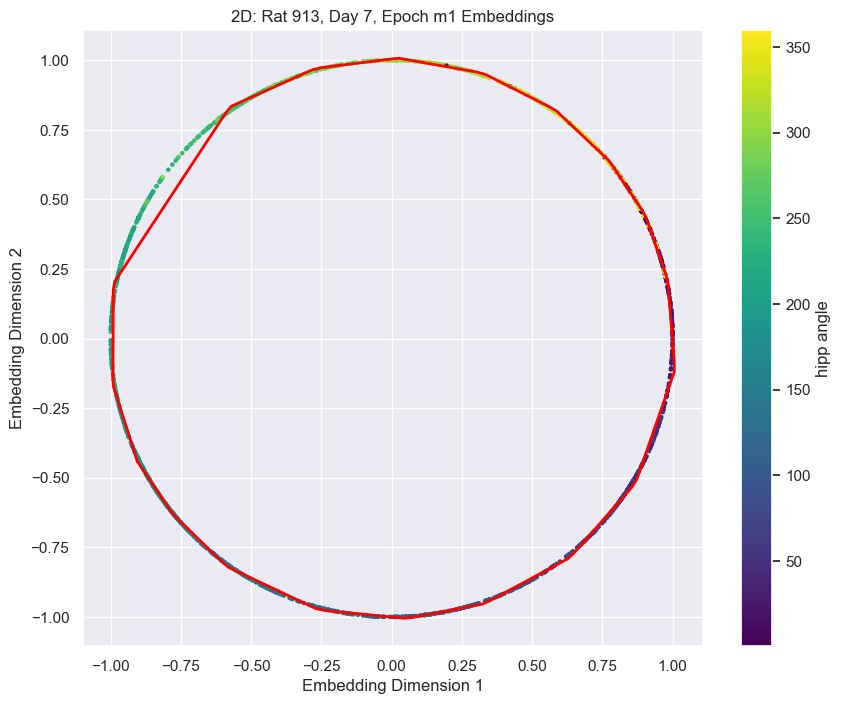

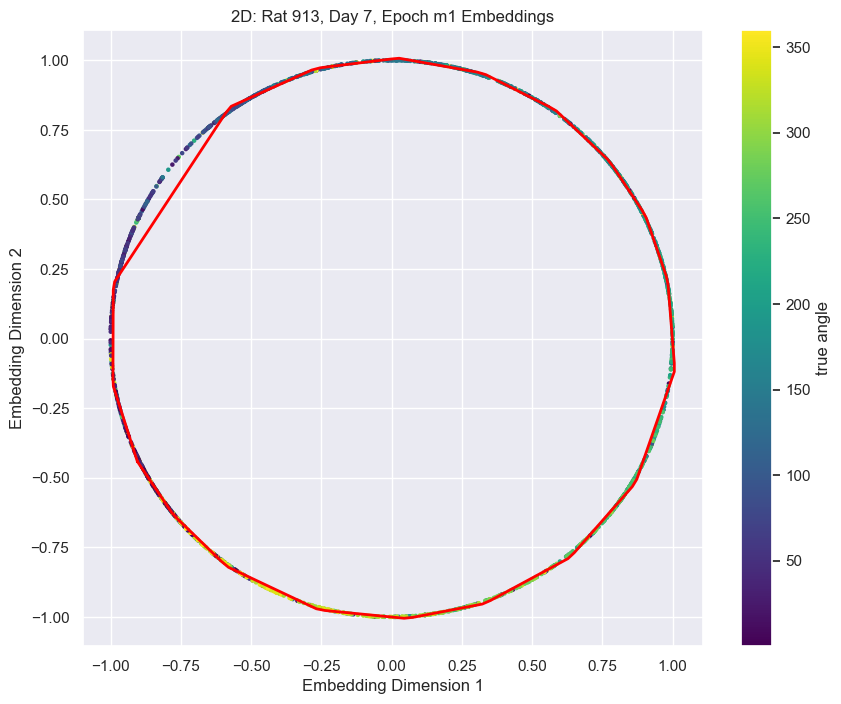

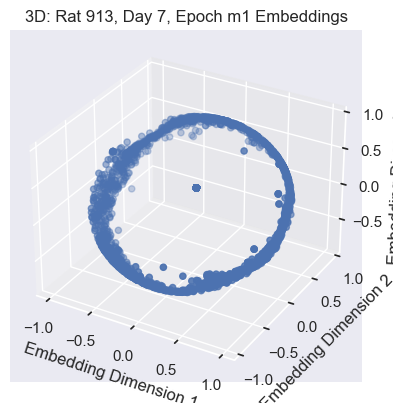

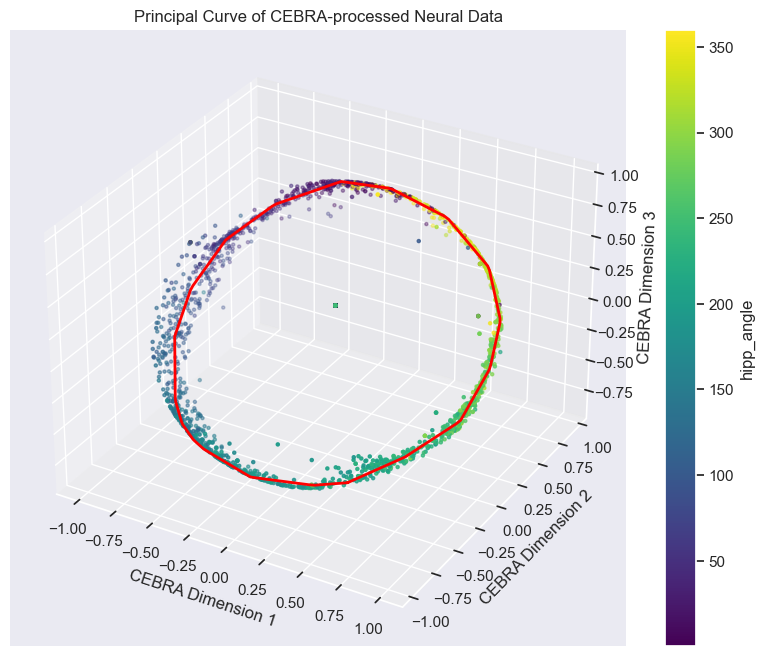

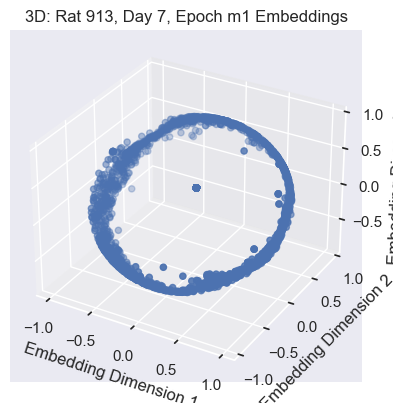

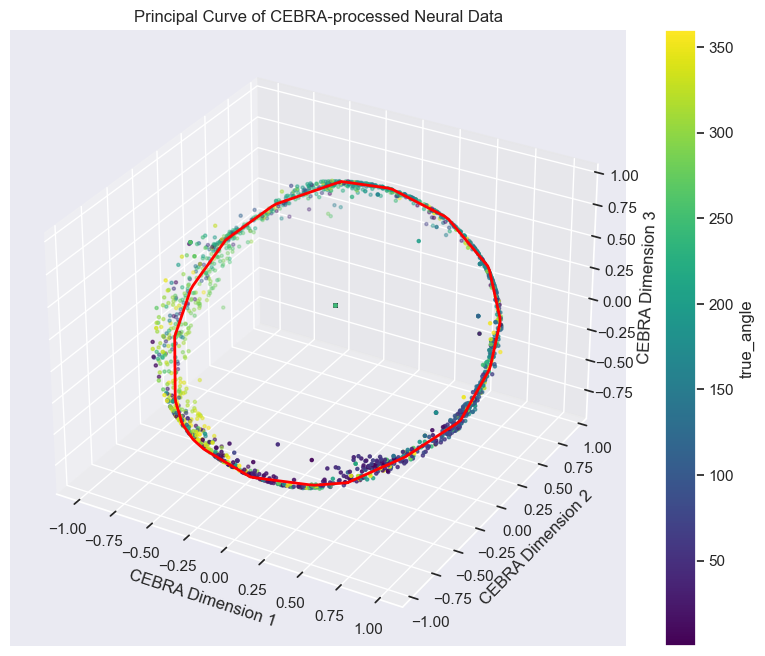

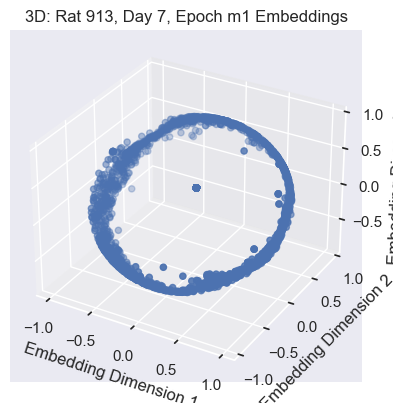

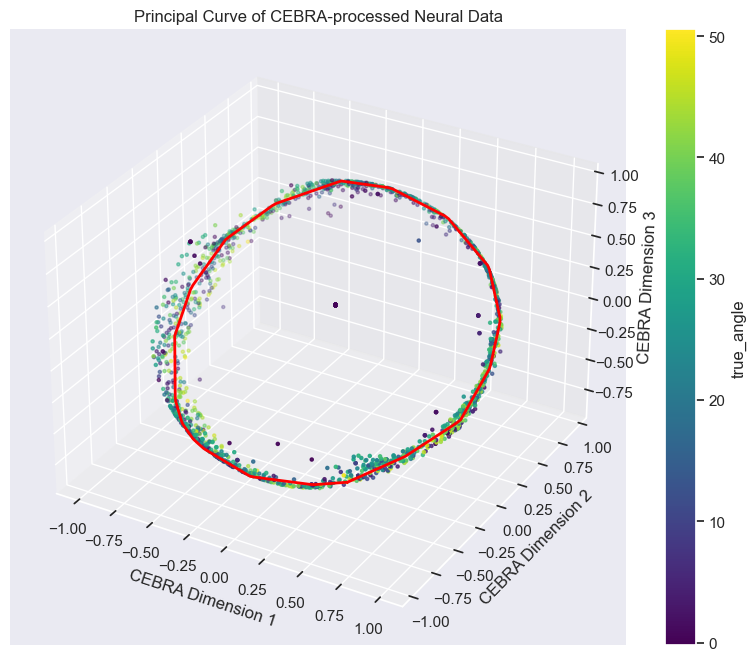

Computing UMAP embeddings...


/opt/anaconda3/envs/NRSC510/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP embeddings shape: (2097, 2)
Saved embedding plots to /Users/devenshidfar/Desktop/Masters/NRSC_510B/cebra_control_recal/results/session_40_embeddings.png
Performing t-SNE embedding...
t-SNE embeddings shape: (2097, 2)


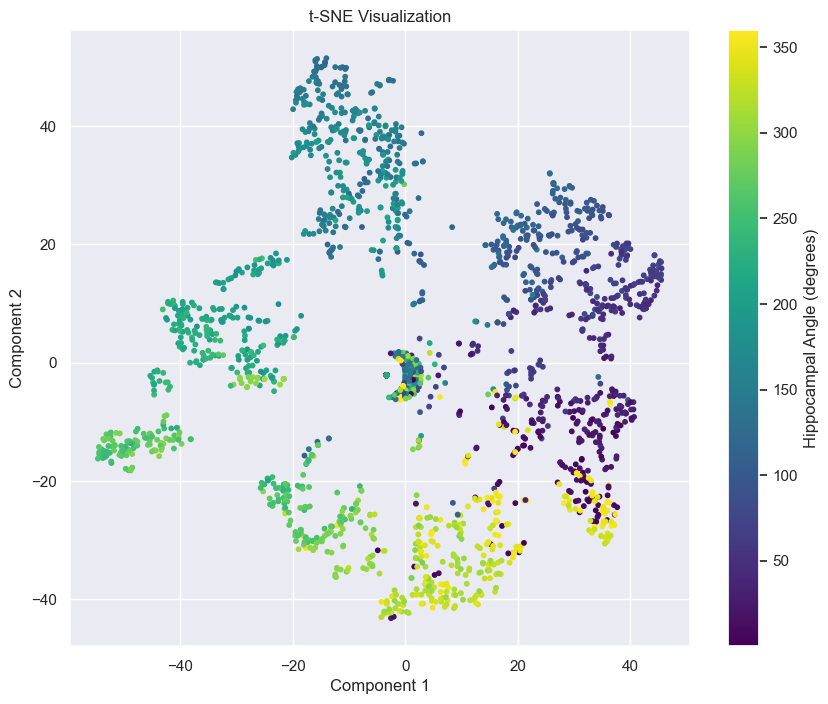

Displayed t-SNE plot.
Created rotating 3D plots for session 40.
Saved embeddings: bin_size-1_embeddings_2d_rat913_day7_epochm1.npy, bin_size-1_embeddings_3d_rat913_day7_epochm1.npy
Saved embeddings metadata to /Users/devenshidfar/Desktop/Masters/NRSC_510B/cebra_control_recal/results/embeddings_metadata.csv

Processing session 41/65
Rat: 913, Day: 9, Epoch: m1
Skipping cluster TT1/cl-maze1.1 due to low isolation quality (4)
Skipping cluster TT11/cl-maze1.11 due to low isolation quality (4)
Skipping cluster TT11/cl-maze1.2 due to low isolation quality (4)
Skipping cluster TT11/cl-maze1.3 due to low isolation quality (4)
Skipping cluster TT11/cl-maze1.7 due to low isolation quality (4)
Skipping cluster TT11/cl-maze1.9 due to low isolation quality (4)
Skipping cluster TT12/cl-maze1.1 due to low isolation quality (4)
Skipping cluster TT14/cl-maze1.7 due to low isolation quality (4)
Skipping cluster TT14/cl-maze1.9 due to low isolation quality (4)
Skipping cluster TT15/cl-maze1.2 due to low 

IndexError: index 20 is out of bounds for axis 0 with size 20

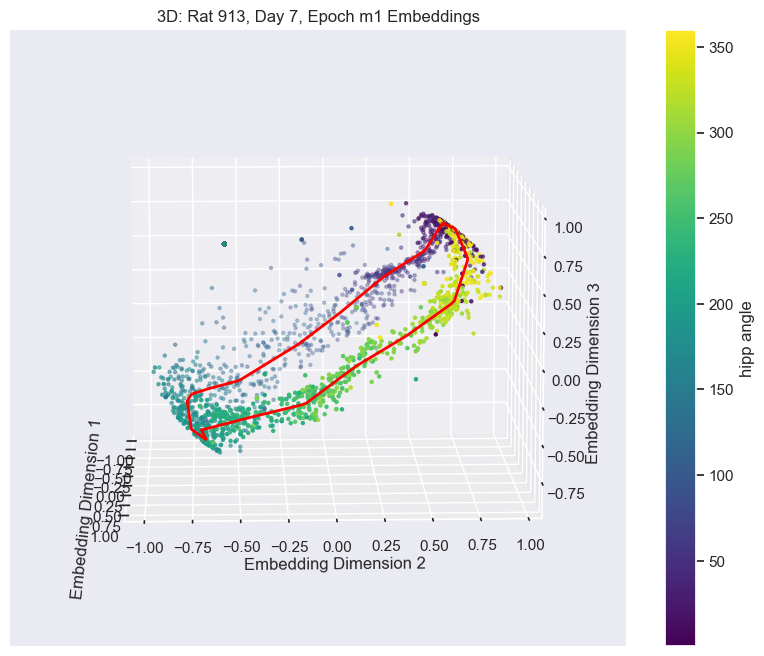

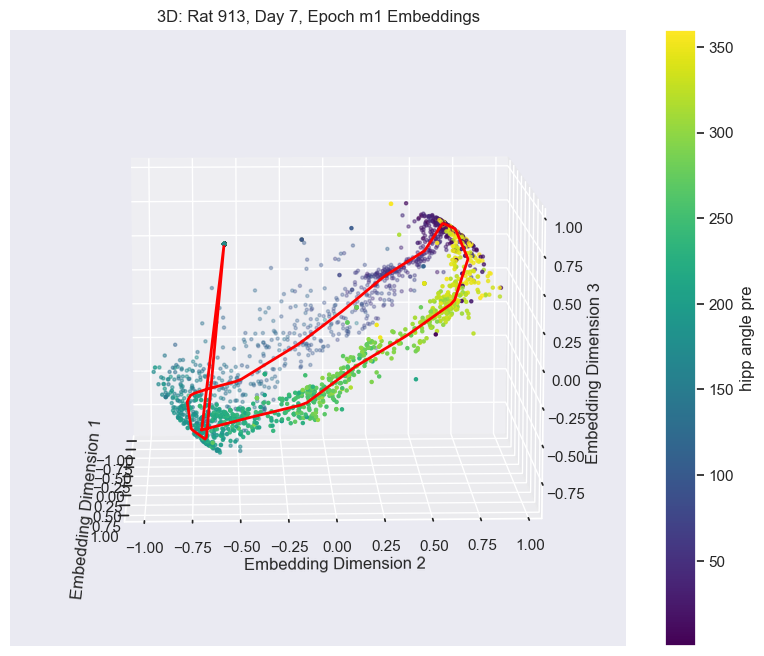

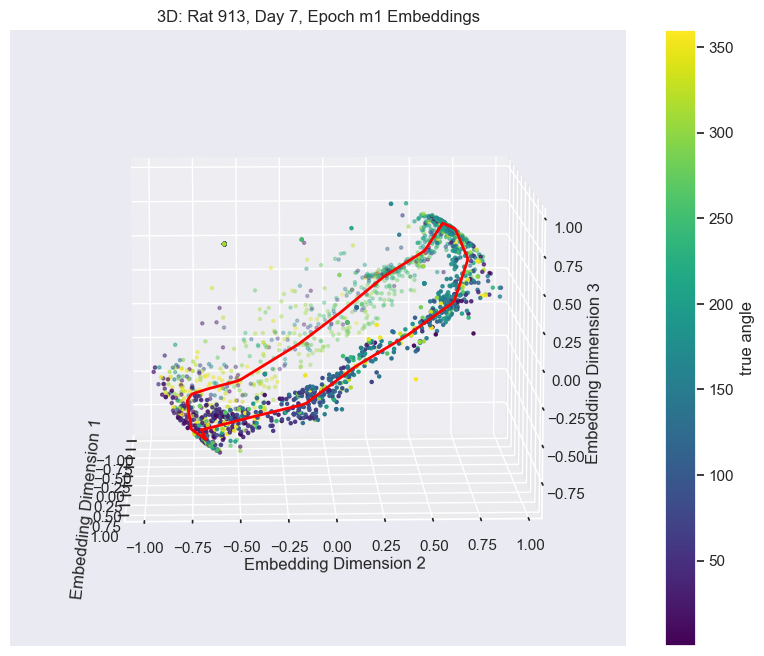

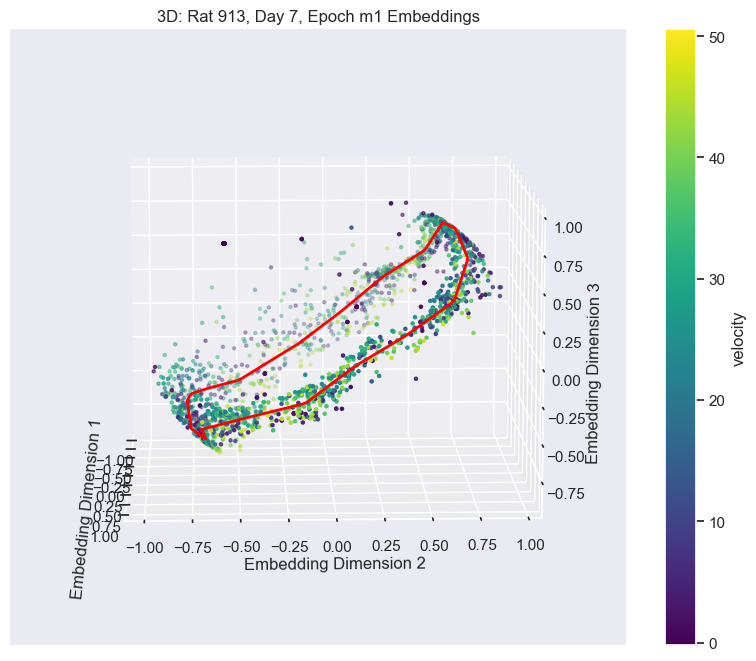

In [3]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
import pickle  # For saving filtered expt
import cebra
# Import your custom functions here
# Ensure these are correctly implemented and accessible
# from your_module import apply_cebra, fit_spud_to_cebra, plot_in_2d, plot_in_3d, plot_embeddings_side_by_side, create_rotating_3d_plot

# -----------------------------
# Configuration Parameters
# -----------------------------
num_trials = 10
control_point = 39
control_count = 0

model_save_path = '/Users/devenshidfar/Desktop/Masters/NRSC_510B/cebra_control_recal/models'
anim_save_path = '/Users/devenshidfar/Desktop/Masters/NRSC_510B/cebra_control_recal/3d_animations'
results_save_path = '/Users/devenshidfar/Desktop/Masters/NRSC_510B/cebra_control_recal/results'

# Set to 1 to save the models and animations
save_models = 1
save_anim = 1

# Create necessary directories
os.makedirs(model_save_path, exist_ok=True)
os.makedirs(anim_save_path, exist_ok=True)
os.makedirs(results_save_path, exist_ok=True)

# Define bin sizes (in seconds)
bin_sizes = [1]  # You can add more bin sizes if needed

# Initialize lists to store embeddings and metadata
embeddings_list = []
metadata_list = []

# Define velocity threshold
vel_threshold = -100 # degrees per second

# -----------------------------
# Main Processing Loop
# -----------------------------
for bin_size in bin_sizes:
    print(f"\nProcessing bin_size: {bin_size} second(s)")

    for session_idx, session in enumerate(expt):
        control_count += 1

        # Control Session Skipping
        if control_count <= control_point:
            print(f"Skipping session {session_idx + 1}")
            continue 
        elif control_count > control_point + num_trials:
            print("Reached the desired number of trials. Exiting session loop.")
            break

        print(f"\nProcessing session {session_idx + 1}/{len(expt)}")
        print(f"Rat: {session.rat}, Day: {session.day}, Epoch: {session.epoch}")

        ros_data = session.rosdata

        start_time = ros_data.startTs
        end_time = ros_data.stopTs

        # Convert encTimes to seconds
        enc_times = np.array(ros_data.encTimes-start_time) / 1e6  # Convert to seconds
        vel = np.array(ros_data.vel)

        # Ensure enc_times and vel are valid
        valid_idx = np.isfinite(enc_times) & np.isfinite(vel)
        enc_times = enc_times[valid_idx]
        vel = vel[valid_idx]

        # Ensure enc_times is sorted
        if not np.all(np.diff(enc_times) >= 0):
            sorted_indices = np.argsort(enc_times)
            enc_times = enc_times[sorted_indices]
            vel = vel[sorted_indices]

        # Get indices where vel > vel_threshold
        high_vel_idx = vel > vel_threshold

        if np.sum(high_vel_idx) == 0:
            print("No data points where vel > vel_threshold. Skipping session.")
            continue

        # Filter enc_times and behavioral variables
        enc_times_high_vel = enc_times[high_vel_idx]
        est_gain = np.array(ros_data.estGain)[valid_idx][high_vel_idx]
        hipp_angle = np.array(ros_data.hippAngle)[valid_idx][high_vel_idx]
        true_angle = np.array(ros_data.encAngle)[valid_idx][high_vel_idx]
        high_vel = vel[high_vel_idx]

        # Define bins over enc_times_high_vel
        bins = np.arange(enc_times_high_vel[0], enc_times_high_vel[-1] + bin_size, bin_size)

        if len(bins) < 2:
            print("Not enough data after filtering for high velocity. Skipping session.")
            continue

        # Bin behavioral variables
        est_gain_binned, _, _ = stats.binned_statistic(enc_times_high_vel, est_gain, statistic='mean', bins=bins)
        hipp_angle_binned, _, _ = stats.binned_statistic(enc_times_high_vel, hipp_angle, statistic='mean', bins=bins)
        true_angle_binned, _, _ = stats.binned_statistic(enc_times_high_vel, true_angle, statistic='mean', bins=bins)
        high_vel_binned, _, _ = stats.binned_statistic(enc_times_high_vel, high_vel, statistic='mean', bins=bins)

        # -----------------------------
        # B. Filter Spike Times Based on High Velocity
        # -----------------------------
        all_spikes = []
        skipped_clusters = 0

        for cluster in session.clust:
            if cluster.isolationQuality > 3:
                print(f"Skipping cluster {cluster.name} due to low isolation quality ({cluster.isolationQuality})")
                skipped_clusters += 1
                continue

            spike_times = (cluster.ts - start_time)

            spike_times_sec = (cluster.ts - start_time) / 1e6  # Convert to seconds

            vel_at_spikes = np.interp(spike_times_sec, enc_times, vel)
    

            # Include spikes where vel_at_spikes > vel_threshold
            include_spikes = vel_at_spikes > vel_threshold
            spike_times_sec_high_vel = spike_times_sec[include_spikes]

            if len(spike_times_sec_high_vel) == 0:
                print(f"No spikes for cluster {cluster.name} at high velocities. Skipping cluster.")
                continue

            # Bin spikes
            binned_spikes, _, _ = stats.binned_statistic(
                spike_times_sec_high_vel, 
                np.ones_like(spike_times_sec_high_vel), 
                statistic='sum', 
                bins=bins
            )

            all_spikes.append(binned_spikes)

        if not all_spikes:
            print("No valid spike data after filtering. Skipping session.")
            continue

        # Assemble neural data
        neural_data = np.array(all_spikes).T  # Shape: (num_bins, num_clusters)
        print(f"neural data: {neural_data[:10,:2]}")

        # -----------------------------
        # C. Consistency Check Between Bins
        # -----------------------------
        num_bins_neural = neural_data.shape[0]
        num_bins_behavior = len(est_gain_binned)

        if num_bins_neural != num_bins_behavior:
            print(f"Warning: Number of neural data bins ({num_bins_neural}) does not match behavioral data bins ({num_bins_behavior}). Adjusting to minimum.")
            min_bins = min(num_bins_neural, num_bins_behavior)
            neural_data = neural_data[:min_bins, :]
            est_gain_binned = est_gain_binned[:min_bins]
            hipp_angle_binned = hipp_angle_binned[:min_bins]
            true_angle_binned = true_angle_binned[:min_bins]
            bins = bins[:min_bins+1]

   
        embeddings_2d_list = []
        embeddings_3d_list = []

        # Apply CEBRA in 2D and 3D
        embeddings_2d = apply_cebra(neural_data, 2)
        embeddings_3d = apply_cebra(neural_data, 3)

        embeddings_2d_list.append(embeddings_2d)
        embeddings_3d_list.append(embeddings_3d)

        # Fit principal curves (adapted from Chaudhuri et al.)
        principal_curve_2d, principal_curve_2d_pre, curve_params_2d = fit_spud_to_cebra(embeddings_2d)
        principal_curve_3d, principal_curve_3d_pre, curve_params_3d = fit_spud_to_cebra(embeddings_3d)

        # Plotting CEBRA 2D embeddings with hippocampal angles
        plot_in_2d(embeddings_2d, session, hipp_angle_binned % 360, "hipp angle", principal_curve_2d)

        # Plotting CEBRA 2D embeddings with true angles
        plot_in_2d(embeddings_2d, session, true_angle_binned % 360, "true angle", principal_curve_2d)

        # # Plotting CEBRA 3D embeddings with hippocampal angles
        plot_in_3d(embeddings_3d, session, hipp_angle_binned % 360, "hipp_angle", principal_curve_3d)

        # Plotting CEBRA 3D embeddings with true angles
        plot_in_3d(embeddings_3d, session, true_angle_binned % 360, "true_angle", principal_curve_3d)

        # Plotting CEBRA 3D embeddings with velocity
        plot_in_3d(embeddings_3d, session, high_vel_binned, "true_angle", principal_curve_3d)

        # Compute UMAP embeddings
        print("Computing UMAP embeddings...")
        umap_reducer = umap.UMAP(n_components=2, random_state=42)
        umap_embeddings = umap_reducer.fit_transform(neural_data)
        print(f"UMAP embeddings shape: {umap_embeddings.shape}")

        # Plot embeddings side by side
        plot_save_path = os.path.join(results_save_path, f"session_{session_idx + 1}_embeddings.png")
        plot_embeddings_side_by_side(
            embeddings_2d=embeddings_2d,
            embeddings_3d=embeddings_3d,
            umap_embeddings=umap_embeddings,
            session=session,
            hipp_angle_binned=hipp_angle_binned,
            true_angle_binned=true_angle_binned,
            principal_curve_2d=principal_curve_2d,
            principal_curve_3d=principal_curve_3d,
            save_path=plot_save_path
        )

        # Perform t-SNE embedding
        print("Performing t-SNE embedding...")
        tsne = TSNE(n_components=2, perplexity=30, random_state=42)
        tsne_embeddings = tsne.fit_transform(neural_data)
        print(f"t-SNE embeddings shape: {tsne_embeddings.shape}")

        # Plot t-SNE embeddings
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], s=10, c=hipp_angle_binned % 360, cmap='viridis')
        plt.title('t-SNE Visualization')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        cbar = plt.colorbar(scatter)
        cbar.set_label('Hippocampal Angle (degrees)')
        plt.show()
        print("Displayed t-SNE plot.")

        # Create rotating 3D plots
        anim_save_file = f"{anim_save_path}/bin_size-{bin_size}/session_{session_idx}/vel_thresh_{vel_threshold}/"
        os.makedirs(anim_save_file,exist_ok=True)
        create_rotating_3d_plot(embeddings_3d, session, hipp_angle_binned % 360, "hipp angle", anim_save_file, save_anim, principal_curve_3d)
        create_rotating_3d_plot(embeddings_3d, session, hipp_angle_binned % 360, "hipp angle pre", anim_save_file, save_anim, principal_curve_3d_pre)
        create_rotating_3d_plot(embeddings_3d, session, true_angle_binned % 360, "true angle", anim_save_file, save_anim, principal_curve_3d)
        create_rotating_3d_plot(embeddings_3d, session, high_vel_binned, "velocity", anim_save_file, save_anim, principal_curve_3d)
        print(f"Created rotating 3D plots for session {session_idx + 1}.")

       
        if save_models:
            embedding_filename_2d = f"bin_size-{bin_size}_embeddings_2d_rat{session.rat}_day{session.day}_epoch{session.epoch}.npy"
            embedding_filename_3d = f"bin_size-{bin_size}_embeddings_3d_rat{session.rat}_day{session.day}_epoch{session.epoch}.npy"
            np.save(os.path.join(model_save_path, embedding_filename_2d), embeddings_2d)
            np.save(os.path.join(model_save_path, embedding_filename_3d), embeddings_3d)
            print(f"Saved embeddings: {embedding_filename_2d}, {embedding_filename_3d}")

        # -----------------------------
        # F. Collect and Save Metadata
        # -----------------------------
        # Collect embeddings and metadata for potential future use
        embeddings_list.append({
            'session_idx': session_idx + 1,
            'rat': session.rat,
            'day': session.day,
            'epoch': session.epoch,
            'bin_size': bin_size,
            'embeddings_2d': embeddings_2d,
            'embeddings_3d': embeddings_3d,
            'hipp_angle_binned': hipp_angle_binned,
            'est_gain_binned': est_gain_binned,
            'true_angle_binned': true_angle_binned
        })

        # Optionally, save metadata to a CSV for reference
        metadata_list.append({
            'session_idx': session_idx + 1,
            'rat': session.rat,
            'day': session.day,
            'epoch': session.epoch,
            'bin_size': bin_size,
            'embedding_filename_2d': embedding_filename_2d,
            'embedding_filename_3d': embedding_filename_3d
        })

        # Save metadata after processing all sessions
        metadata_df = pd.DataFrame(metadata_list)
        metadata_csv_path = os.path.join(results_save_path, 'embeddings_metadata.csv')
        metadata_df.to_csv(metadata_csv_path, index=False)
        print(f"Saved embeddings metadata to {metadata_csv_path}")

'''
filtered_expt_save_path = '/Users/devenshidfar/Desktop/Masters/NRSC_510B/cebra_control_recal_project/mat_code_and_data/data/NN_opticflow_dataset_filtered.pkl'
with open(filtered_expt_save_path, 'wb') as f:
    pickle.dump(expt, f)
print(f"Filtered expt structure saved to {filtered_expt_save_path}")
'''

test labels true[219.78501344 311.16018922 287.22657594 314.07714235 200.92190797
   0.95440797  71.09210328  94.00188844 183.68557985 253.57034547]
test labels hipp[298.64365133 138.39859803  20.0251714   71.39041332 109.35143679
 191.9959482  248.03224438  99.84166444  95.42548658  55.98657955]
hipp angle pred [272.59038191 185.78048562 185.78048562 185.78048562 185.78048562
 185.78048562 185.78048562 185.78048562 185.78048562 185.78048562]


/var/folders/j3/sgby32516rl80nxb7vn4p93w0000gn/T/ipykernel_25518/1121527686.py:192: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels_bar, rotation=45, ha='right')


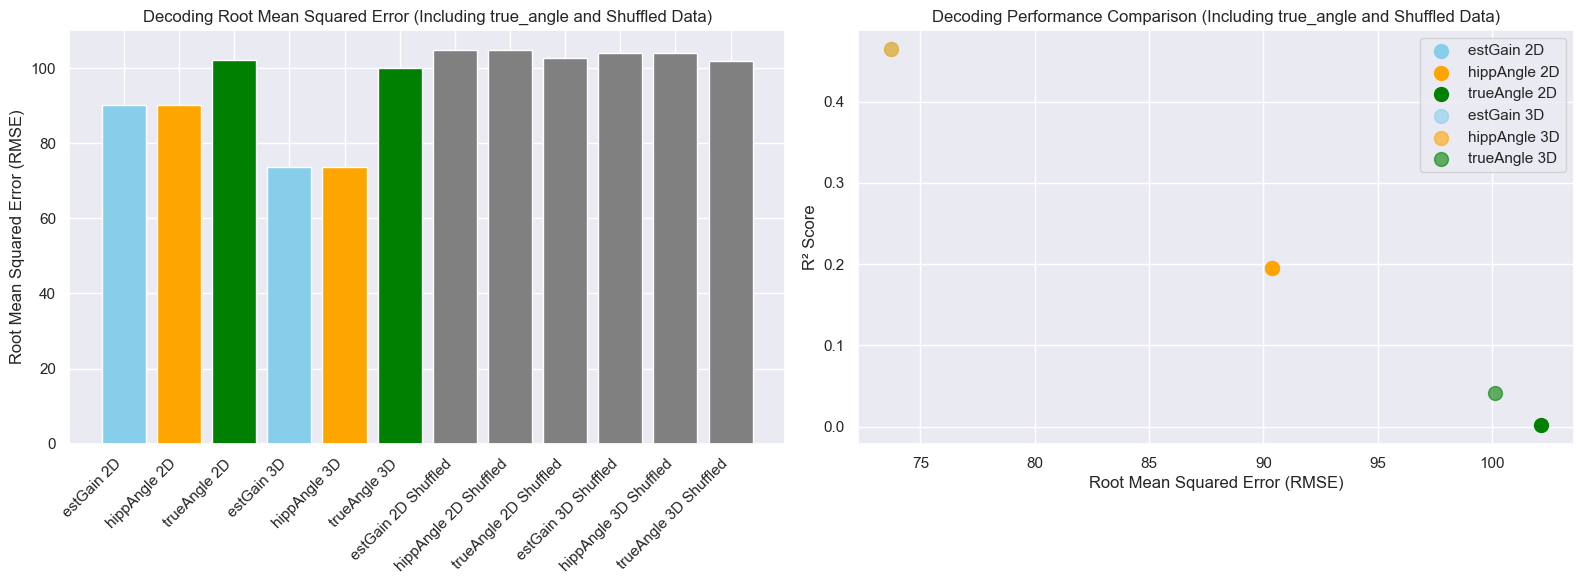

,Embedding Dimension,Variable,R² Score,RMSE
0,2D,estGain,0.194884,90.362386
1,2D,hippAngle,0.194884,90.362386
2,2D,trueAngle,0.002368,102.155773
3,3D,estGain,0.464471,73.697058
4,3D,hippAngle,0.464471,73.697058
5,3D,trueAngle,0.041276,100.143887
6,2D Shuffled,estGain,-0.032826,104.904317
7,2D Shuffled,hippAngle,-0.032826,104.904317
8,2D Shuffled,trueAngle,-0.021608,102.756413
9,3D Shuffled,estGain,-0.016922,104.093471


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd

hipp_angle_binned = hipp_angle_binned % 360
true_angle_binned = true_angle_binned % 360
shuffled_est_gain_binned = np.random.permutation(est_gain_binned)
shuffled_hipp_angle_binned = np.random.permutation(hipp_angle_binned)
shuffled_true_angle_binned = np.random.permutation(true_angle_binned)


def evaluate_decoding(true, pred):
    r2 = r2_score(true, pred)
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    return r2, rmse


# make sure variables are defined and raise error if not
required_vars = ['embeddings_2d', 'embeddings_3d', 'hipp_angle_binned', 'est_gain_binned']
for var in required_vars:
    if var not in globals():
        raise ValueError(f"Variable '{var}' is not defined.")
    

# embeddings_2d = apply_cebra(neural_data,2)
# embeddings_3d = apply_cebra(neural_data,3)

# Split the data into training and testing sets
# Using 80% for training and 20% for testing
# Setting a random state for reproducibility
# Split the data into training and testing sets for hipp_angle
# Split the data into training and testing sets for hipp_angle
train_emb_2d_hipp, test_emb_2d_hipp, train_labels_hipp, test_labels_hipp = train_test_split(
    embeddings_2d, hipp_angle_binned, test_size=0.2, random_state=42
)

train_emb_3d_hipp, test_emb_3d_hipp, train_labels_hipp_3d, test_labels_hipp_3d = train_test_split(
    embeddings_3d, hipp_angle_binned, test_size=0.2, random_state=42
)

# Split the data into training and testing sets for true_angle
train_emb_2d_true, test_emb_2d_true, train_labels_true, test_labels_true = train_test_split(
    embeddings_2d, true_angle_binned, test_size=0.2, random_state=42
)

train_emb_3d_true, test_emb_3d_true, train_labels_true_3d, test_labels_true_3d = train_test_split(
    embeddings_3d, true_angle_binned, test_size=0.2, random_state=42
)

# Split the data into training and testing sets for shuffled hipp_angle
train_emb_2d_shuffled_hipp, test_emb_2d_shuffled_hipp, train_labels_shuffled_hipp, test_labels_shuffled_hipp = train_test_split(
    embeddings_2d, shuffled_hipp_angle_binned, test_size=0.2, random_state=42
)

train_emb_3d_shuffled_hipp, test_emb_3d_shuffled_hipp, train_labels_shuffled_hipp_3d, test_labels_shuffled_hipp_3d = train_test_split(
    embeddings_3d, shuffled_hipp_angle_binned, test_size=0.2, random_state=42
)

# Split the data into training and testing sets for shuffled true_angle
train_emb_2d_shuffled_true, test_emb_2d_shuffled_true, train_labels_shuffled_true, test_labels_shuffled_true = train_test_split(
    embeddings_2d, shuffled_true_angle_binned, test_size=0.2, random_state=42
)

train_emb_3d_shuffled_true, test_emb_3d_shuffled_true, train_labels_shuffled_true_3d, test_labels_shuffled_true_3d = train_test_split(
    embeddings_3d, shuffled_true_angle_binned, test_size=0.2, random_state=42
)



# Initialize kNN Decoders for estGain and hippAngle
knn_est_gain_2d = cebra.KNNDecoder(n_neighbors=50, metric='cosine')
knn_hipp_angle_2d = cebra.KNNDecoder(n_neighbors=50, metric='cosine')

knn_est_gain_3d = cebra.KNNDecoder(n_neighbors=50, metric='cosine')
knn_hipp_angle_3d = cebra.KNNDecoder(n_neighbors=50, metric='cosine')

#shuffled hipp

knn_est_gain_2d_shuffled = cebra.KNNDecoder(n_neighbors=50, metric='cosine')
knn_hipp_angle_2d_shuffled = cebra.KNNDecoder(n_neighbors=50, metric='cosine')

knn_est_gain_3d_shuffled = cebra.KNNDecoder(n_neighbors=50, metric='cosine')
knn_hipp_angle_3d_shuffled = cebra.KNNDecoder(n_neighbors=50, metric='cosine')

# Initialize kNN Decoders for true_angle
knn_true_angle_2d = cebra.KNNDecoder(n_neighbors=50, metric='cosine')
knn_true_angle_3d = cebra.KNNDecoder(n_neighbors=50, metric='cosine')

# Shuffled decoders for true_angle
knn_true_angle_2d_shuffled = cebra.KNNDecoder(n_neighbors=50, metric='cosine')
knn_true_angle_3d_shuffled = cebra.KNNDecoder(n_neighbors=50, metric='cosine')


# Train decoders on 2D embeddings for estGain and hippAngle
knn_est_gain_2d.fit(train_emb_2d_hipp, train_labels_hipp)     # estGain
knn_hipp_angle_2d.fit(train_emb_2d_hipp, train_labels_hipp)   # hippAngle

# Train decoders on 3D embeddings for estGain and hippAngle
knn_est_gain_3d.fit(train_emb_3d_hipp, train_labels_hipp_3d)     # estGain
knn_hipp_angle_3d.fit(train_emb_3d_hipp, train_labels_hipp_3d)   # hippAngle

# Train decoders on 2D embeddings for shuffled hippAngle
knn_est_gain_2d_shuffled.fit(train_emb_2d_shuffled_hipp, train_labels_shuffled_hipp)     # estGain
knn_hipp_angle_2d_shuffled.fit(train_emb_2d_shuffled_hipp, train_labels_shuffled_hipp)   # hippAngle

# Train decoders on 3D embeddings for shuffled hippAngle
knn_est_gain_3d_shuffled.fit(train_emb_3d_shuffled_hipp, train_labels_shuffled_hipp_3d)     # estGain
knn_hipp_angle_3d_shuffled.fit(train_emb_3d_shuffled_hipp, train_labels_shuffled_hipp_3d)   # hippAngle

# Train decoders on 2D and 3D embeddings for true_angle
knn_true_angle_2d.fit(train_emb_2d_true, train_labels_true)  # true_angle 2D
knn_true_angle_3d.fit(train_emb_3d_true, train_labels_true_3d)  # true_angle 3D

# train Shuffled data training for true_angle
knn_true_angle_2d_shuffled.fit(train_emb_2d_shuffled_true, train_labels_shuffled_true)  # true_angle 2D Shuffled
knn_true_angle_3d_shuffled.fit(train_emb_3d_shuffled_true, train_labels_shuffled_true_3d)  # true_angle 3D Shuffled


# Predict on 2D test embeddings for estGain and hippAngle
est_gain_pred_2d = knn_est_gain_2d.predict(test_emb_2d_hipp)
hipp_angle_pred_2d = knn_hipp_angle_2d.predict(test_emb_2d_hipp)

# Predict on 3D test embeddings for estGain and hippAngle
est_gain_pred_3d = knn_est_gain_3d.predict(test_emb_3d_hipp)
hipp_angle_pred_3d = knn_hipp_angle_3d.predict(test_emb_3d_hipp)

# Predict on 2D test embeddings for shuffled hippAngle
est_gain_pred_2d_shuffled = knn_est_gain_2d_shuffled.predict(test_emb_2d_shuffled_hipp)
hipp_angle_pred_2d_shuffled = knn_hipp_angle_2d_shuffled.predict(test_emb_2d_shuffled_hipp)

# Predict on 3D test embeddings for shuffled hippAngle
est_gain_pred_3d_shuffled = knn_est_gain_3d_shuffled.predict(test_emb_3d_shuffled_hipp)
hipp_angle_pred_3d_shuffled = knn_hipp_angle_3d_shuffled.predict(test_emb_3d_shuffled_hipp)

# Predictions on 2D and 3D test embeddings for true_angle
true_angle_pred_2d = knn_true_angle_2d.predict(test_emb_2d_true)
true_angle_pred_3d = knn_true_angle_3d.predict(test_emb_3d_true)

# Shuffled predictions for true_angle on 2D and 3D test embeddings
true_angle_pred_2d_shuffled = knn_true_angle_2d_shuffled.predict(test_emb_2d_shuffled_true)
true_angle_pred_3d_shuffled = knn_true_angle_3d_shuffled.predict(test_emb_3d_shuffled_true)




print(f"test labels true{test_labels_true[:10]}")
print(f"test labels hipp{test_labels_hipp[:10]}")
print(f"hipp angle pred {hipp_angle_pred_2d[:10]}")
# 2D Embeddings Evaluation
# 2D Embeddings Evaluation for estGain and hippAngle
r2_est_2d, rmse_est_2d = evaluate_decoding(test_labels_hipp, est_gain_pred_2d)
r2_hipp_2d, rmse_hipp_2d = evaluate_decoding(test_labels_hipp, hipp_angle_pred_2d)

# 3D Embeddings Evaluation for estGain and hippAngle
r2_est_3d, rmse_est_3d = evaluate_decoding(test_labels_hipp_3d, est_gain_pred_3d)
r2_hipp_3d, rmse_hipp_3d = evaluate_decoding(test_labels_hipp_3d, hipp_angle_pred_3d)

# 2D Embeddings Evaluation for shuffled hippAngle
r2_est_2d_shuffled, rmse_est_2d_shuffled = evaluate_decoding(test_labels_shuffled_hipp, est_gain_pred_2d_shuffled)
r2_hipp_2d_shuffled, rmse_hipp_2d_shuffled = evaluate_decoding(test_labels_shuffled_hipp, hipp_angle_pred_2d_shuffled)

# 3D Embeddings Evaluation for shuffled hippAngle
r2_est_3d_shuffled, rmse_est_3d_shuffled = evaluate_decoding(test_labels_shuffled_hipp_3d, est_gain_pred_3d_shuffled)
r2_hipp_3d_shuffled, rmse_hipp_3d_shuffled = evaluate_decoding(test_labels_shuffled_hipp_3d, hipp_angle_pred_3d_shuffled)

# 2D and 3D Embeddings Evaluation for true_angle
r2_true_2d, rmse_true_2d = evaluate_decoding(test_labels_true, true_angle_pred_2d)
r2_true_3d, rmse_true_3d = evaluate_decoding(test_labels_true_3d, true_angle_pred_3d)

# Shuffled data evaluation for true_angle
r2_true_2d_shuffled, rmse_true_2d_shuffled = evaluate_decoding(test_labels_shuffled_true, true_angle_pred_2d_shuffled)
r2_true_3d_shuffled, rmse_true_3d_shuffled = evaluate_decoding(test_labels_shuffled_true_3d, true_angle_pred_3d_shuffled)



# Vis of decoding errors
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Bar Plot for RMSE 
rmse_values = [rmse_est_2d, rmse_hipp_2d, rmse_true_2d, rmse_est_3d, rmse_hipp_3d, rmse_true_3d,
               rmse_est_2d_shuffled, rmse_hipp_2d_shuffled, rmse_true_2d_shuffled, rmse_est_3d_shuffled, rmse_hipp_3d_shuffled, rmse_true_3d_shuffled]
labels_bar = ['estGain 2D', 'hippAngle 2D', 'trueAngle 2D', 'estGain 3D', 'hippAngle 3D', 'trueAngle 3D',
              'estGain 2D Shuffled', 'hippAngle 2D Shuffled', 'trueAngle 2D Shuffled', 'estGain 3D Shuffled', 'hippAngle 3D Shuffled', 'trueAngle 3D Shuffled']
colors_bar = ['skyblue', 'orange', 'green', 'skyblue', 'orange', 'green', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray']

ax[0].bar(labels_bar, rmse_values, color=colors_bar)
ax[0].set_ylabel('Root Mean Squared Error (RMSE)')
ax[0].set_title('Decoding Root Mean Squared Error (Including true_angle and Shuffled Data)')
ax[0].set_xticklabels(labels_bar, rotation=45, ha='right')

# Scatter Plot of R2 Score vs rmse
ax[1].scatter(rmse_est_2d, r2_est_2d, label='estGain 2D', color='skyblue', s=100)
ax[1].scatter(rmse_hipp_2d, r2_hipp_2d, label='hippAngle 2D', color='orange', s=100)
ax[1].scatter(rmse_true_2d, r2_true_2d, label='trueAngle 2D', color='green', s=100)
ax[1].scatter(rmse_est_3d, r2_est_3d, label='estGain 3D', color='skyblue', alpha=0.6, s=100)
ax[1].scatter(rmse_hipp_3d, r2_hipp_3d, label='hippAngle 3D', color='orange', alpha=0.6, s=100)
ax[1].scatter(rmse_true_3d, r2_true_3d, label='trueAngle 3D', color='green', alpha=0.6, s=100)
ax[1].set_xlabel('Root Mean Squared Error (RMSE)')
ax[1].set_ylabel('R² Score')
ax[1].set_title('Decoding Performance Comparison (Including true_angle and Shuffled Data)')
ax[1].legend()

plt.tight_layout()
plt.show()

# Create a summary table of decoding performance
data = {
    'Embedding Dimension': ['2D', '2D', '2D', '3D', '3D', '3D', '2D Shuffled', '2D Shuffled', '2D Shuffled', '3D Shuffled', '3D Shuffled', '3D Shuffled'],
    'Variable': ['estGain', 'hippAngle', 'trueAngle', 'estGain', 'hippAngle', 'trueAngle', 
                 'estGain', 'hippAngle', 'trueAngle', 'estGain', 'hippAngle', 'trueAngle'],
    'R² Score': [r2_est_2d, r2_hipp_2d, r2_true_2d, r2_est_3d, r2_hipp_3d, r2_true_3d, 
                 r2_est_2d_shuffled, r2_hipp_2d_shuffled, r2_true_2d_shuffled, r2_est_3d_shuffled, r2_hipp_3d_shuffled, r2_true_3d_shuffled],
    'RMSE': [rmse_est_2d, rmse_hipp_2d, rmse_true_2d, rmse_est_3d, rmse_hipp_3d, rmse_true_3d, 
             rmse_est_2d_shuffled, rmse_hipp_2d_shuffled, rmse_true_2d_shuffled, rmse_est_3d_shuffled, rmse_hipp_3d_shuffled, rmse_true_3d_shuffled]
}

df = pd.DataFrame(data)
display(df)

#save the stats
# df.to_csv('/decoding_results.csv', index=False)

